# (16) Table1: MC vs. Exact

**Motivation**: Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def detect_dead_neurons(tr: TrainerVAE):
    dead_thres = {
        'poisson': 0.008,
        'gaussian': 0.08,
        'laplace': 0.08,
    }
    data, loss, etc = tr.validate()

    if tr.model.cfg.type == 'categorical':
        thres = None
        dead = np.zeros(np.prod(tr.model.size))
    else:
        thres = dead_thres.get(tr.model.cfg.type)
        dead = loss['kl_diag'] < thres
    return data, loss, etc, thres, dead.astype(bool)

## Fig save dir

In [3]:
from figures.imgs import plot_weights

fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 600,
}

[]

## Device

In [4]:
device_idx = 0
device = f'cuda:{device_idx}'

## Load, make df

In [5]:
root = add_home('Dropbox/chkpts/PoissonVAE')
fits = [f for f in sorted(os.listdir(root)) if 'st_chewie' not in f]
fits_st = [f for f in sorted(os.listdir(root)) if 'st_chewie' in f]

len(fits), len(fits_st)

(519, 90)

In [6]:
attrs = [
    'dataset',
    'type', 'enc_type', 'dec_type', 'latent_act',
    'n_latents', 'n_categories', 'seed',
]
df = collections.defaultdict(list)
for name in tqdm(fits):
    dec = name.split('-')[1].split('|')[-1].split('>')[0]
    if dec != 'lin':
        continue

    tr, meta = load_quick(
        pjoin(root, name),
        lite=True,
        device=device,
        verbose=False,
    )
    data, loss, etc = tr.validate()
    loss_avg = {k: v.mean() for k, v in loss.items()}
    loss_avg['nelbo'] = loss_avg['mse'] + loss_avg['kl']

    vals = {k: meta[k] for k in ['checkpoint', 'timestamp']}
    vals.update({a: getattr(tr.model.cfg, a, None) for a in attrs})
    vals['n_params'] = sum([p.numel() for p in tr.parameters()])
    vals['method'] = tr.cfg.method
    vals.update(loss_avg)

    for k, v in vals.items():
        df[k].append(v)

df = pd.DataFrame(df)

  0%|                                                   | 0/519 [00:00<?, ?it/s]/home/hadi/Dropbox/git/_PoissonVAE/base/common.py:353: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
100%|█████████████████████████████████████████| 519/519 [11:24<00:00,  1.32s/it]


In [7]:
df

checkpoint         timestamp          dataset         type enc_type  \
0          1500  2024_05_15,02:05  CIFAR10-PATCHES  categorical     conv   
1          1500  2024_05_15,11:37  CIFAR10-PATCHES  categorical     conv   
2          1500  2024_05_15,21:14  CIFAR10-PATCHES  categorical     conv   
3          1500  2024_05_16,06:50  CIFAR10-PATCHES  categorical     conv   
4          1500  2024_05_14,21:24  CIFAR10-PATCHES  categorical     conv   
..          ...               ...              ...          ...      ...   
473        1200  2024_05_14,18:10            MNIST      poisson      mlp   
474        1200  2024_05_14,02:28            MNIST      poisson      mlp   
475        1200  2024_05_14,09:04            MNIST      poisson      mlp   
476        1200  2024_05_14,15:59            MNIST      poisson      mlp   
477        1200  2024_05_14,23:14            MNIST      poisson      mlp   

    dec_type latent_act  n_latents  n_categories  seed  n_params method  \
0        lin       None          1         512.0     1   1405084  exact   
1        lin       None          1         512.0     2   1405084  exact   
2        lin       None          1         512.0     3   1405084  exact   
3        lin       None          1         512.0     4   1405084  exact   
4        lin       None          1         512.0     1   1405084     mc   
..       ...        ...        ...           ...   ...       ...    ...   
473      lin       None        512           NaN     1  20487728     mc   
474      lin       None        512           NaN     2  20487728     mc   
475      lin       None        512           NaN     3  20487728     mc   
476      lin       None        512           NaN     4  20487728     mc   
477      lin       None        512           NaN     5  20487728     mc   

            mse        kl   kl_diag       nelbo  
0    174.093353  6.044831  6.044831  180.138184  
1    174.858093  6.034148  6.034148  180.892242  
2    174.635742  6.034076  6.034076  180.669815  
3    174.558258  6.044322  6.044322  180.602585  
4    170.705414  5.840983  5.840983  176.546402  
..          ...       ...       ...         ...  
473   31.339325  8.698847  0.016990   40.038170  
474   31.358475  8.734622  0.017060   40.093098  
475   31.292654  8.673033  0.016940   39.965687  
476   31.360594  8.698561  0.016989   40.059155  
477   31.317518  8.716907  0.017025   40.034424  

[478 rows x 16 columns]

In [27]:
df_selected = df.loc[
    (df['latent_act'].isnull()) &
    (df['enc_type'] != 'mlp')
]
df_selected.shape

(203, 16)

In [35]:
df_selected

checkpoint         timestamp          dataset         type enc_type  \
0          1500  2024_05_15,02:05  CIFAR10-PATCHES  categorical     conv   
1          1500  2024_05_15,11:37  CIFAR10-PATCHES  categorical     conv   
2          1500  2024_05_15,21:14  CIFAR10-PATCHES  categorical     conv   
3          1500  2024_05_16,06:50  CIFAR10-PATCHES  categorical     conv   
4          1500  2024_05_14,21:24  CIFAR10-PATCHES  categorical     conv   
..          ...               ...              ...          ...      ...   
443        1200  2024_05_14,15:02            MNIST      poisson      lin   
444        1200  2024_05_14,22:15            MNIST      poisson      lin   
445        1200  2024_05_14,06:13            MNIST      poisson      lin   
446        1200  2024_05_14,12:59            MNIST      poisson      lin   
447        1200  2024_05_14,19:59            MNIST      poisson      lin   

    dec_type latent_act  n_latents  n_categories  seed  n_params method  \
0        lin       None          1         512.0     1   1405084  exact   
1        lin       None          1         512.0     2   1405084  exact   
2        lin       None          1         512.0     3   1405084  exact   
3        lin       None          1         512.0     4   1405084  exact   
4        lin       None          1         512.0     1   1405084     mc   
..       ...        ...        ...           ...   ...       ...    ...   
443      lin       None        512           NaN     1    803328     mc   
444      lin       None        512           NaN     2    803328     mc   
445      lin       None        512           NaN     3    803328     mc   
446      lin       None        512           NaN     4    803328     mc   
447      lin       None        512           NaN     5    803328     mc   

            mse        kl   kl_diag       nelbo  
0    174.093353  6.044831  6.044831  180.138184  
1    174.858093  6.034148  6.034148  180.892242  
2    174.635742  6.034076  6.034076  180.669815  
3    174.558258  6.044322  6.044322  180.602585  
4    170.705414  5.840983  5.840983  176.546402  
..          ...       ...       ...         ...  
443   33.282413  8.503514  0.016608   41.785927  
444   33.214127  8.516159  0.016633   41.730286  
445   33.092651  8.510839  0.016623   41.603493  
446   33.156258  8.499963  0.016601   41.656219  
447   33.295475  8.509435  0.016620   41.804909  

[203 rows x 16 columns]

In [44]:
group_cols = ['dataset', 'type', 'enc_type', 'method']
df_avg = df_selected.groupby(by=group_cols).mean(numeric_only=True)
df_avg

checkpoint  n_latents  \
dataset         type        enc_type method                          
CIFAR10-PATCHES categorical conv     exact       1500.0        1.0   
                                     mc          1500.0        1.0   
                            lin      exact       1500.0        1.0   
                                     mc          1500.0        1.0   
                gaussian    conv     exact       1500.0      512.0   
                                     mc          1500.0      512.0   
                            lin      exact       1500.0      512.0   
                                     mc          1500.0      512.0   
                laplace     conv     exact       1500.0      512.0   
                                     mc          1500.0      512.0   
                            lin      exact       1500.0      512.0   
                                     mc          1500.0      512.0   
                poisson     conv     exact       1500.0      512.0   
                                     mc          1500.0      512.0   
                            lin      exact       1500.0      512.0   
                                     mc          1500.0      512.0   
DOVES           categorical conv     exact       3000.0        1.0   
                                     mc          3000.0        1.0   
                            lin      exact       3000.0        1.0   
                                     mc          3000.0        1.0   
                gaussian    conv     exact       3000.0      512.0   
                                     mc          3000.0      512.0   
                            lin      exact       3000.0      512.0   
                                     mc          3000.0      512.0   
                laplace     conv     exact       3000.0      512.0   
                                     mc          3000.0      512.0   
                            lin      exact       3000.0      512.0   
                                     mc          3000.0      512.0   
                poisson     conv     exact       3000.0      512.0   
                                     mc          3000.0      512.0   
                            lin      exact       3000.0      512.0   
                                     mc          3000.0      512.0   
MNIST           categorical conv     exact       1200.0        1.0   
                                     mc          1200.0        1.0   
                            lin      exact       1200.0        1.0   
                                     mc          1200.0        1.0   
                gaussian    conv     exact       1200.0      512.0   
                                     mc          1200.0      512.0   
                            lin      exact       1200.0      512.0   
                                     mc          1200.0      512.0   
                laplace     conv     exact       1200.0      512.0   
                                     mc          1200.0      512.0   
                            lin      exact       1200.0      512.0   
                                     mc          1200.0      512.0   
                poisson     conv     exact       1200.0      512.0   
                                     mc          1200.0      512.0   
                            lin      exact       1200.0      512.0   
                                     mc          1200.0      512.0   

                                             n_categories  seed   n_params  \
dataset         type        enc_type method                                  
CIFAR10-PATCHES categorical conv     exact          512.0   2.5  1405084.0   
                                     mc             512.0   3.0  1405084.0   
                            lin      exact          512.0   3.0   262144.0   
                                     mc             512.0   3.0   262144.0   
                gaussian    conv     exact            NaN   3.0  1471132.0  

In [45]:
a = df_selected.groupby(by=group_cols)['nelbo'].agg(list)

In [46]:
for index, value in a.items():
    print("Index:", index, "Value:", value)

Index:
('CIFAR10-PATCHES', 'categorical', 'conv', 'exact')
Value:
[180.13818359375, 180.89224243164062, 180.66981506347656, 180.6025848388672]

Index:
('CIFAR10-PATCHES', 'categorical', 'conv', 'mc')
Value:
[176.54640197753906, 176.49183654785156, 176.40829467773438, 176.4200439453125, 176.48049926757812]

Index:
('CIFAR10-PATCHES', 'categorical', 'lin', 'exact')
Value:
[177.0965118408203, 177.15211486816406, 177.10379028320312, 177.198486328125, 177.09954833984375]

Index:
('CIFAR10-PATCHES', 'categorical', 'lin', 'mc')
Value:
[174.64102172851562, 174.69520568847656, 174.684814453125, 174.69032287597656, 174.72897338867188]

Index:
('CIFAR10-PATCHES', 'gaussian', 'conv', 'exact')
Value:
[149.20077514648438, 149.184814453125]

Index:
('CIFAR10-PATCHES', 'gaussian', 'conv', 'mc')
Value:
[149.22784423828125, 149.2368621826172]

Index:
('CIFAR10-PATCHES', 'gaussian', 'lin', 'exact')
Value:
[165.8238067626953, 165.78671264648438, 165.9171600341797, 165.8271484375, 165.94976806640625]

Index:
('CIFAR10-PATCHES', 'gaussian', 'lin', 'mc')
Value:
[165.83901977539062, 165.87985229492188, 165.86746215820312, 165.96466064453125, 165.84754943847656]

Index:
('CIFAR10-PATCHES', 'laplace', 'conv', 'exact')
Value:
[154.36074829101562, 154.3318634033203, 154.35516357421875, 154.3611297607422]

Index:
('CIFAR10-PATCHES', 'laplace', 'conv', 'mc')
Value:
[154.443115234375, 154.52517700195312, 154.5300750732422, 154.5535125732422, 154.48117065429688]

Index:
('CIFAR10-PATCHES', 'laplace', 'lin', 'exact')
Value:
[170.21923828125, 170.12301635742188, 170.13230895996094, 170.08030700683594, 170.13436889648438]

Index:
('CIFAR10-PATCHES', 'laplace', 'lin', 'mc')
Value:
[170.12271118164062, 170.00045776367188, 170.06597900390625, 170.06076049804688, 170.07308959960938]

Index:
('CIFAR10-PATCHES', 'poisson', 'conv', 'exact')
Value:
[162.1020965576172]

Index:
('CIFAR10-PATCHES', 'poisson', 'conv', 'mc')
Value:
[162.9320068359375, 162.97633361816406]

Index:
('CIFAR10-PATCHES', 'poisson', 'lin', 'exact')
Value:
[167.29100036621094, 167.05245971679688, 167.05911254882812, 167.08168029785156, 167.03213500976562]

Index:
('CIFAR10-PATCHES', 'poisson', 'lin', 'mc')
Value:
[167.37478637695312, 167.3026123046875, 167.3483428955078, 167.34140014648438, 167.28848266601562]

Index:
('DOVES', 'categorical', 'conv', 'exact')
Value:
[186.6784210205078]

Index:
('DOVES', 'categorical', 'conv', 'mc')
Value:
[171.7435302734375, 171.90533447265625]

Index:
('DOVES', 'categorical', 'lin', 'exact')
Value:
[174.97903442382812, 174.88047790527344, 175.0136260986328, 174.9761962890625, 174.83143615722656]

Index:
('DOVES', 'categorical', 'lin', 'mc')
Value:
[170.433837890625, 170.50439453125, 170.4735870361328, 170.502685546875, 170.5012664794922]

Index:
('DOVES', 'gaussian', 'conv', 'exact')
Value:
[154.41131591796875, 154.40408325195312, 154.34872436523438, 154.3526611328125, 154.42999267578125]

Index:
('DOVES', 'gaussian', 'conv', 'mc')
Value:
[154.457275390625, 154.41758728027344, 154.42779541015625, 154.37710571289062, 154.42205810546875]

Index:
('DOVES', 'gaussian', 'lin', 'exact')
Value:
[160.29562377929688, 160.37646484375, 160.32269287109375, 160.4324188232422, 160.30323791503906]

Index:
('DOVES', 'gaussian', 'lin', 'mc')
Value:
[160.27774047851562, 160.31455993652344, 160.2152862548828, 160.33094787597656, 160.3409881591797]

Index:
('DOVES', 'laplace', 'conv', 'exact')
Value:
[158.93682861328125, 159.01817321777344]

Index:
('DOVES', 'laplace', 'conv', 'mc')
Value:
[159.1189727783203, 159.35983276367188]

Index:
('DOVES', 'laplace', 'lin', 'exact')
Value:
[167.32266235351562, 167.30517578125, 167.3486785888672, 167.31661987304688, 167.3675537109375]

Index:
('DOVES', 'laplace', 'lin', 'mc')
Value:
[167.3756103515625, 167.3081512451172, 167.36428833007812, 167.33184814453125, 167.34603881835938]

Index:
('DOVES', 'poisson', 'conv', 'exact')
Value:
[162.54754638671875, 162.26992797851562, 162.32760620117188, 162.4830322265625, 162.5035400390625]

Index:
('DOVES', 'poisson', 'conv', 'mc')
Value:
[163.3902587890625, 163.35826110839844, 163.35311889648438, 163.28012084960938, 163.49893188476562]

Index:
('DOVES', 'poisson', 'lin', 'exact')
Value:
[168.4957275390625, 168.22645568847656, 168.32638549804688, 167.5585174560547, 167.526611328125]

Index:
('DOVES', 'poisson', 'lin', 'mc')
Value:
[167.24642944335938, 167.1602325439453, 167.119873046875, 167.22137451171875, 167.10458374023438]

Index:
('MNIST', 'categorical', 'conv', 'exact')
Value:
[59.135074615478516, 59.13502502441406, 59.13508987426758]

Index:
('MNIST', 'categorical', 'conv', 'mc')
Value:
[35.88841247558594, 59.134376525878906, 59.139156341552734]

Index:
('MNIST', 'categorical', 'lin', 'exact')
Value:
[56.490234375, 55.78322219848633, 56.532257080078125, 55.7138671875, 55.877742767333984]

Index:
('MNIST', 'categorical', 'lin', 'mc')
Value:
[39.68386459350586, 39.894248962402344, 39.59043502807617, 39.80326461791992, 39.777652740478516]

Index:
('MNIST', 'gaussian', 'conv', 'exact')
Value:
[40.072486877441406, 40.00803756713867, 40.02027893066406, 39.999935150146484]

Index:
('MNIST', 'gaussian', 'conv', 'mc')
Value:
[40.10683822631836, 40.08671569824219, 40.10142135620117, 40.067039489746094, 40.063316345214844]

Index:
('MNIST', 'gaussian', 'lin', 'exact')
Value:
[40.60163116455078, 40.527713775634766, 40.50861740112305, 40.526954650878906, 40.59222412109375]

Index:
('MNIST', 'gaussian', 'lin', 'mc')
Value:
[40.705413818359375, 40.686073303222656, 40.63188934326172, 40.65092849731445, 40.67352294921875]

Index:
('MNIST', 'laplace', 'conv', 'exact')
Value:
[40.98294448852539, 40.99547576904297, 40.99799728393555]

Index:
('MNIST', 'laplace', 'conv', 'mc')
Value:
[40.990840911865234, 41.020538330078125, 41.0460090637207]

Index:
('MNIST', 'laplace', 'lin', 'exact')
Value:
[42.10520935058594, 41.99394989013672, 42.08384704589844, 42.098487854003906, 42.18696212768555]

Index:
('MNIST', 'laplace', 'lin', 'mc')
Value:
[42.148223876953125, 42.10078811645508, 42.12898254394531, 42.10932159423828, 42.147037506103516]

Index:
('MNIST', 'poisson', 'conv', 'exact')
Value:
[39.799495697021484, 39.65928649902344, 39.72886276245117, 39.77765655517578, 39.49691390991211]

Index:
('MNIST', 'poisson', 'conv', 'mc')
Value:
[40.27238082885742, 39.99652099609375, 40.086647033691406, 40.03008270263672, 40.053714752197266]

Index:
('MNIST', 'poisson', 'lin', 'exact')
Value:
[41.49271774291992, 41.45032501220703, 41.422664642333984, 41.47850799560547, 41.442779541015625]

Index:
('MNIST', 'poisson', 'lin', 'mc')
Value:
[41.785926818847656, 41.73028564453125, 41.603492736816406, 41.656219482421875, 41.804908752441406]

In [195]:
data = a[('DOVES', 'poisson', 'conv', 'exact')]

boot = sp_stats.bootstrap(
    data=(data,),
    n_resamples=1000000,
    statistic=np.mean,
    paired=True,
)
print(boot)

BootstrapResult(
    confidence_interval=ConfidenceInterval(low=162.32408447265624, high=162.512939453125),
    bootstrap_distribution=array([162.4392334 , 162.4392334 , 162.31665039, ..., 162.31607056,
       162.45741577, 162.35869141]),
    standard_error=0.04820227851772785
)

In [196]:
e = boot.standard_error * get_tval(4, 0.95)
(np.mean(data) - e, np.mean(data) + e)

(162.2924995861563, 162.5601615466562)

In [197]:
data = a[('DOVES', 'poisson', 'conv', 'mc')]

boot = sp_stats.bootstrap(
    data=(data,),
    n_resamples=1000000,
    statistic=np.mean,
    paired=True,
)
print(boot)

BootstrapResult(
    confidence_interval=ConfidenceInterval(low=163.3249481201172, high=163.44906311035157),
    bootstrap_distribution=array([163.35440369, 163.37510986, 163.33848267, ..., 163.41887207,
       163.42630005, 163.3927948 ]),
    standard_error=0.031825872496181726
)

In [198]:
e = boot.standard_error * get_tval(4, 0.95)
(np.mean(data) - e, np.mean(data) + e)

(163.28777551775337, 163.46450109357474)

In [226]:
test = sp_stats.ttest_rel(
    a=a[('DOVES', 'poisson', 'conv', 'exact')],
    b=a[('DOVES', 'poisson', 'conv', 'mc')],
)
test.statistic, test.pvalue

(-17.087879749280134, 6.879351416486745e-05)

In [227]:
test = sp_stats.ttest_rel(
    a=a[('CIFAR10-PATCHES', 'poisson', 'lin', 'exact')],
    b=a[('CIFAR10-PATCHES', 'poisson', 'lin', 'mc')],
)
test.statistic, test.pvalue

(-6.218841029317539, 0.0034035040482166697)

## Load model, plot dec weights

In [15]:


models2load = {
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [16]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 262.7 K

# params: 394.2 K

# params: 394.2 K

poisson, # dead: 8

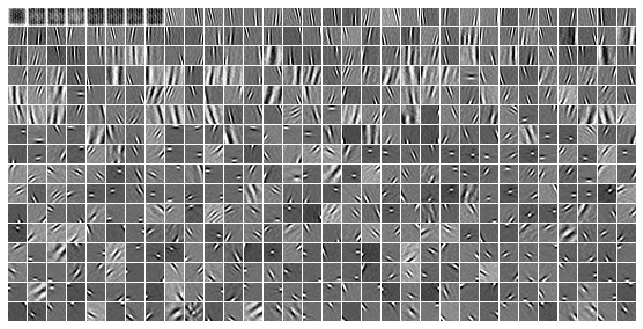

categorical, # dead: 0

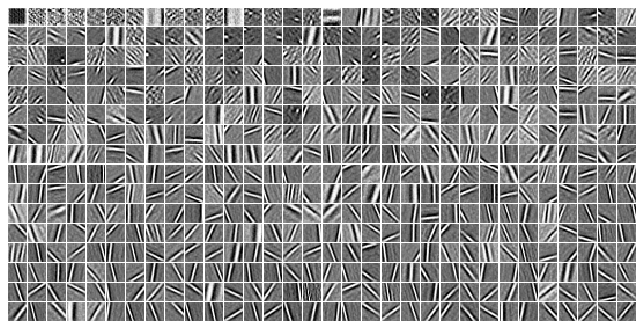

gaussian, # dead: 401

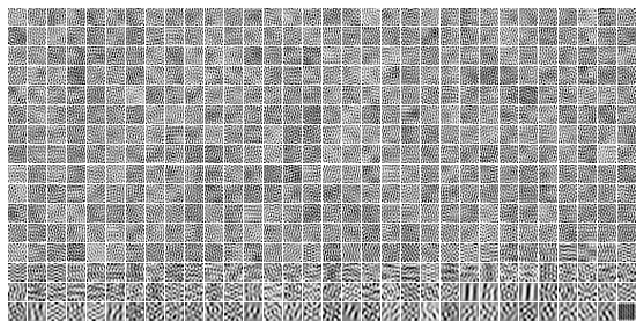

laplace, # dead: 416

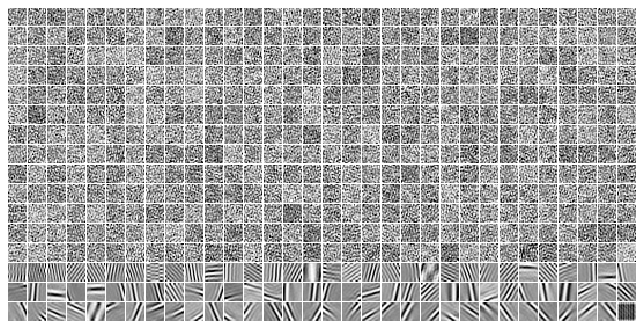

CPU times: user 6.7 s, sys: 2.86 s, total: 9.56 s
Wall time: 9.55 s


In [17]:
%%time

for name, tr in trainers.items():
    data, loss, etc, thres, dead = detect_dead_neurons(tr)
    print(f"{name}, # dead: {dead.sum()}")
    
    if tr.model.cfg.type == 'categorical':
        order = etc['logits'].mean(0).ravel()
        order = np.argsort(order)[::-1]
    else:
        order = np.argsort(loss['kl_diag'])
    fig, ax = tr.model.show(order=order, dpi=80) # , figsize=(16, 8))
    # save
    fname = '_'.join([
        'phi',
        tr.model.cfg.enc_type,
        f"{tr.model.cfg.type}.png",
    ])
    fname = pjoin(fig_dir, fname)
    fig.savefig(fname=fname, **kws_fig)

## Explore models, one by one

### Poisson

In [7]:
tr = trainers['poisson']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 137.7962, 'kl': 29.459375, 'kl_diag': 0.056859836, 'tot': 167.25558}

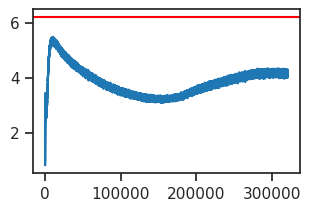

In [8]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

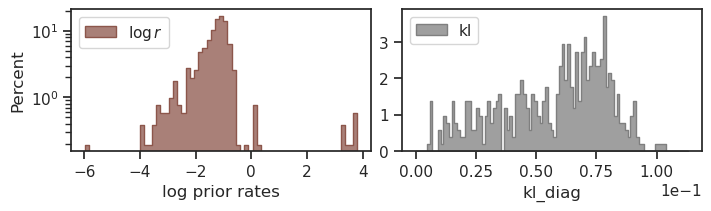

In [9]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(tr.model.log_rate.squeeze()), label=r'$\log r$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

add_legend(axes, loc='upper left')
axes[0].set(xlabel='log prior rates', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='linear')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

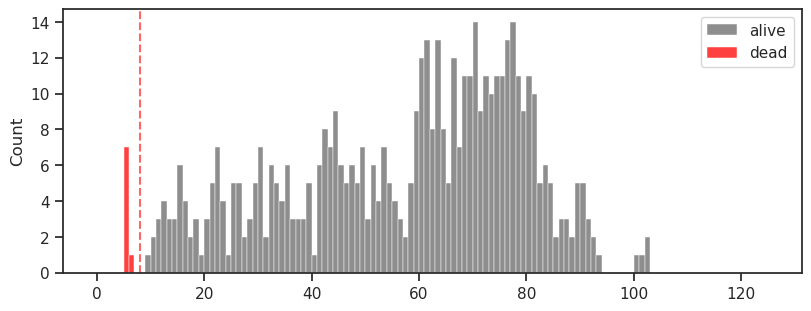

In [10]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 125, 126)
sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

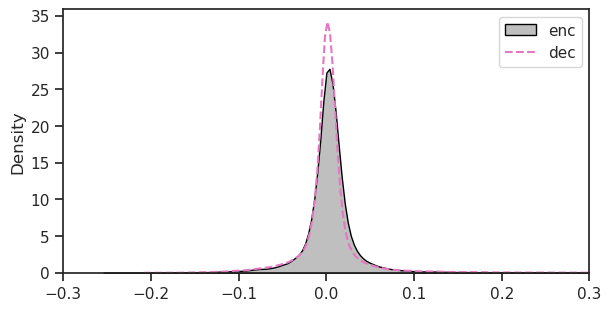

In [11]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

In [12]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

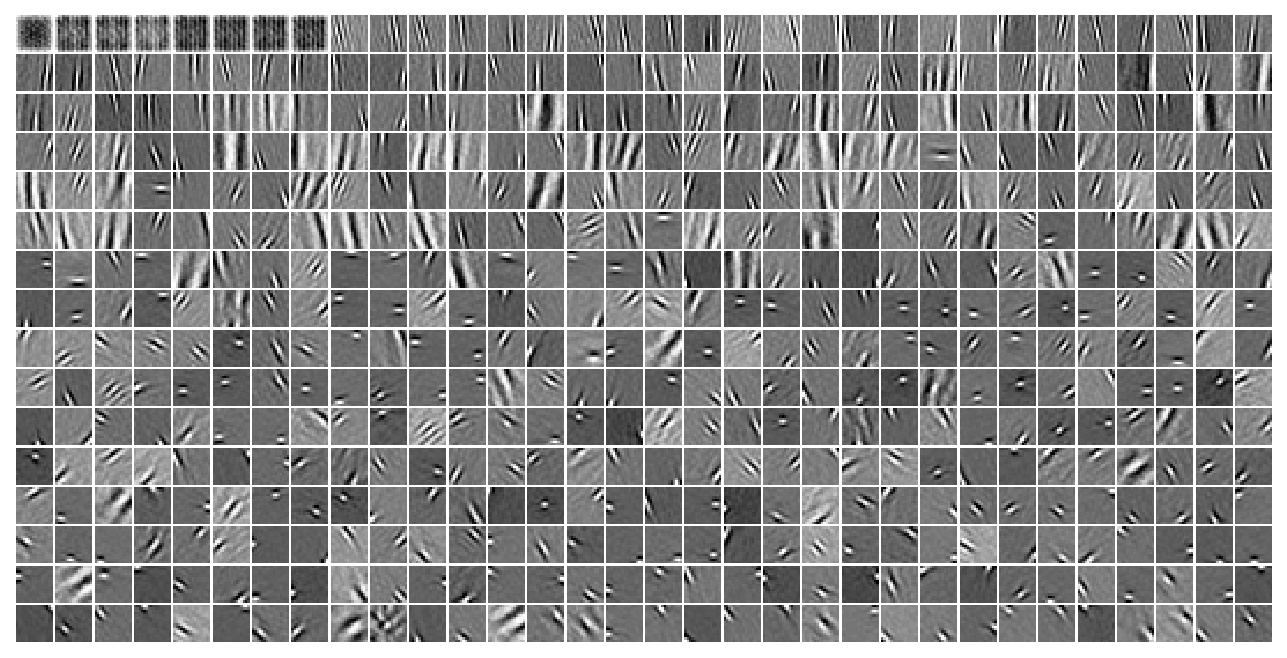

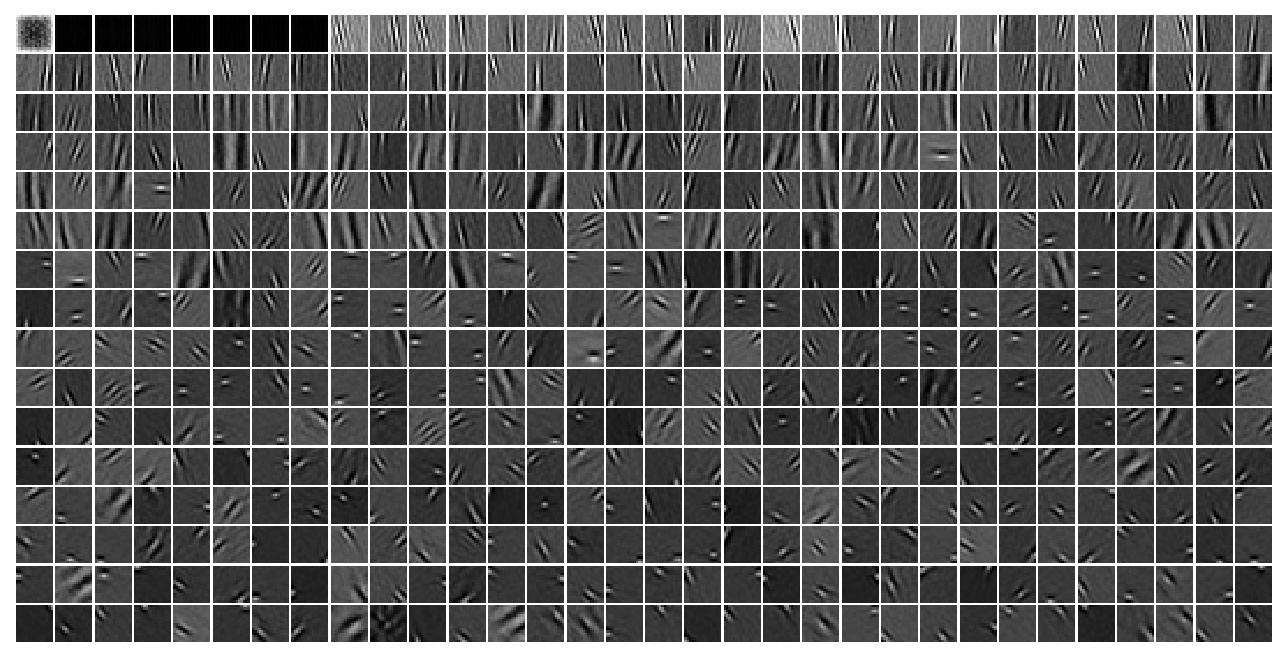

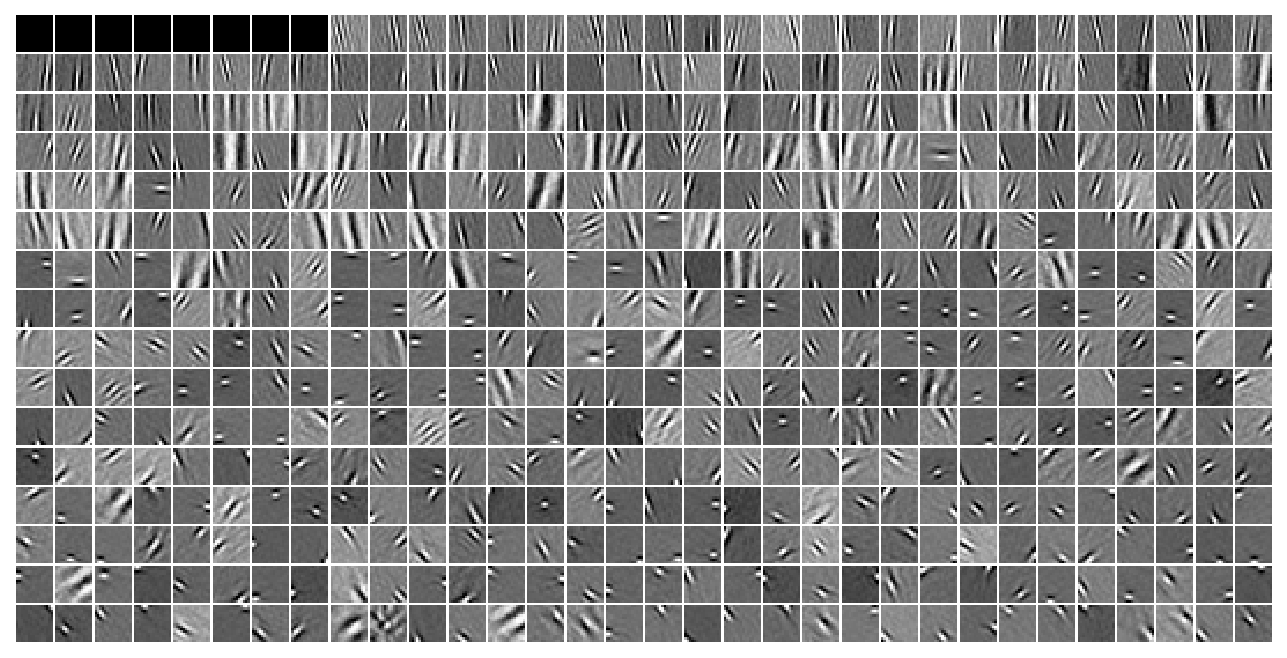

In [13]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

### Gaussian

In [14]:
tr = trainers['gaussian']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 122.805855, 'kl': 37.543747, 'kl_diag': 0.07292354, 'tot': 160.34961}

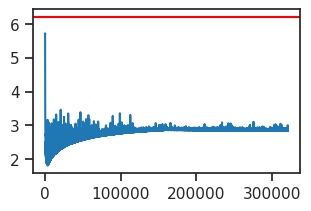

In [15]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

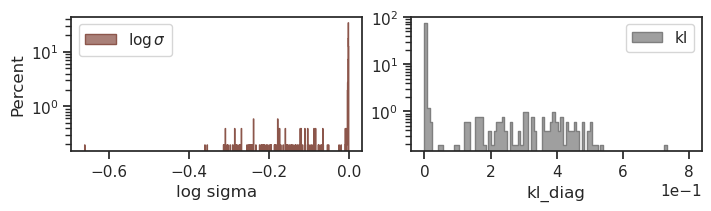

In [16]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

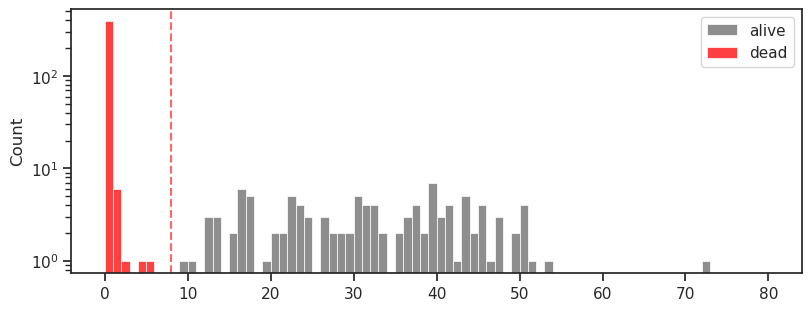

In [17]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
plt.show()

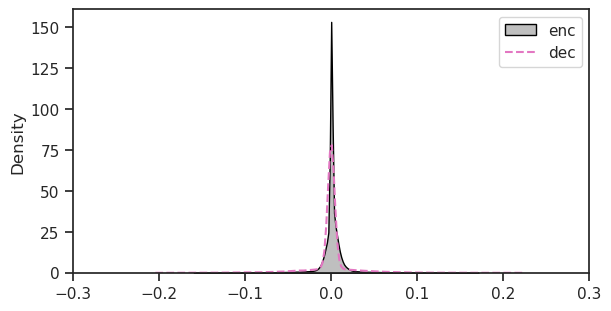

In [18]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

In [19]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

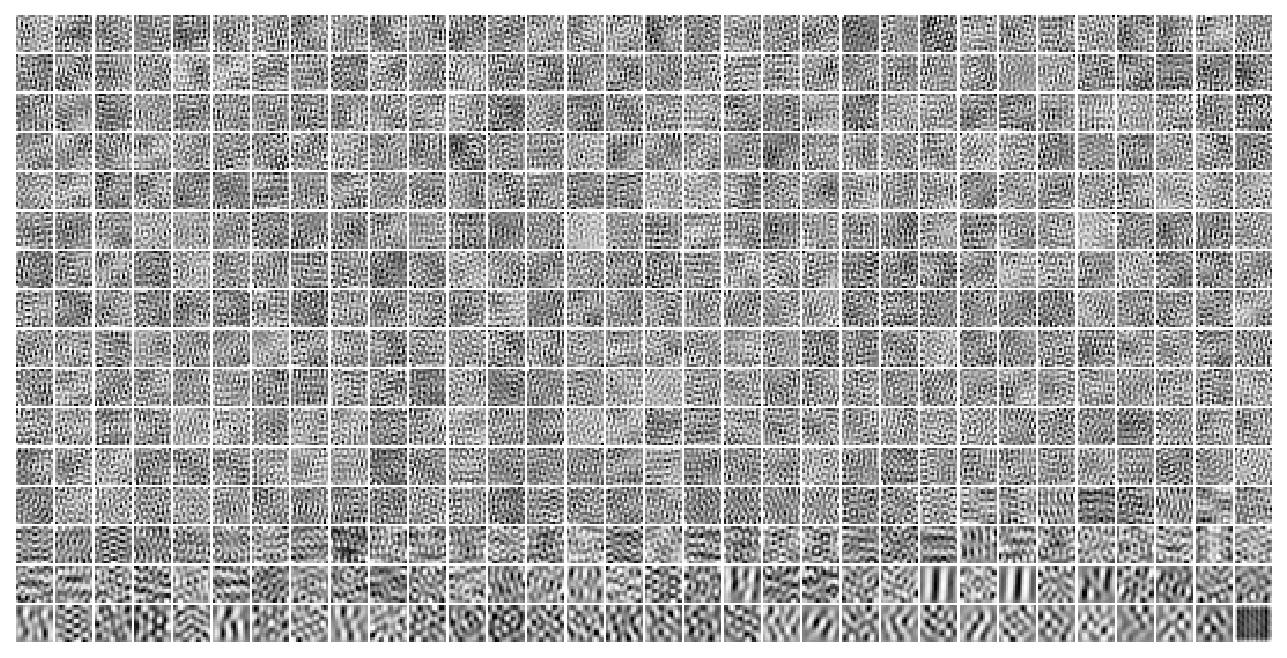

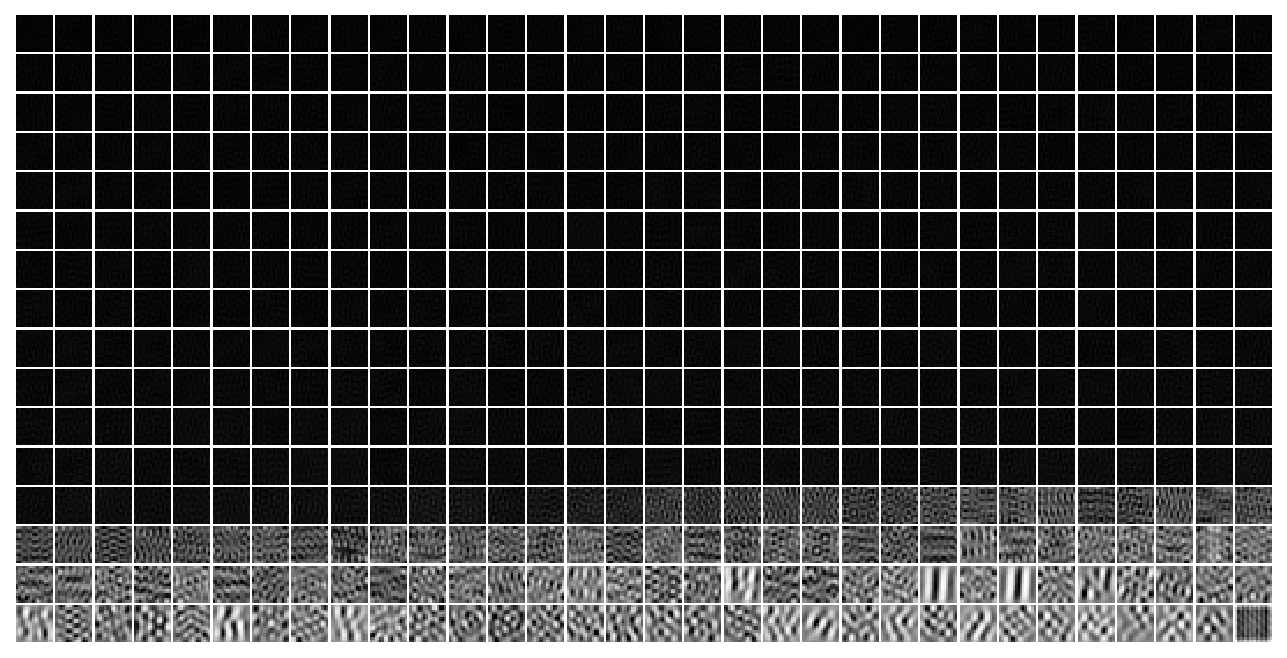

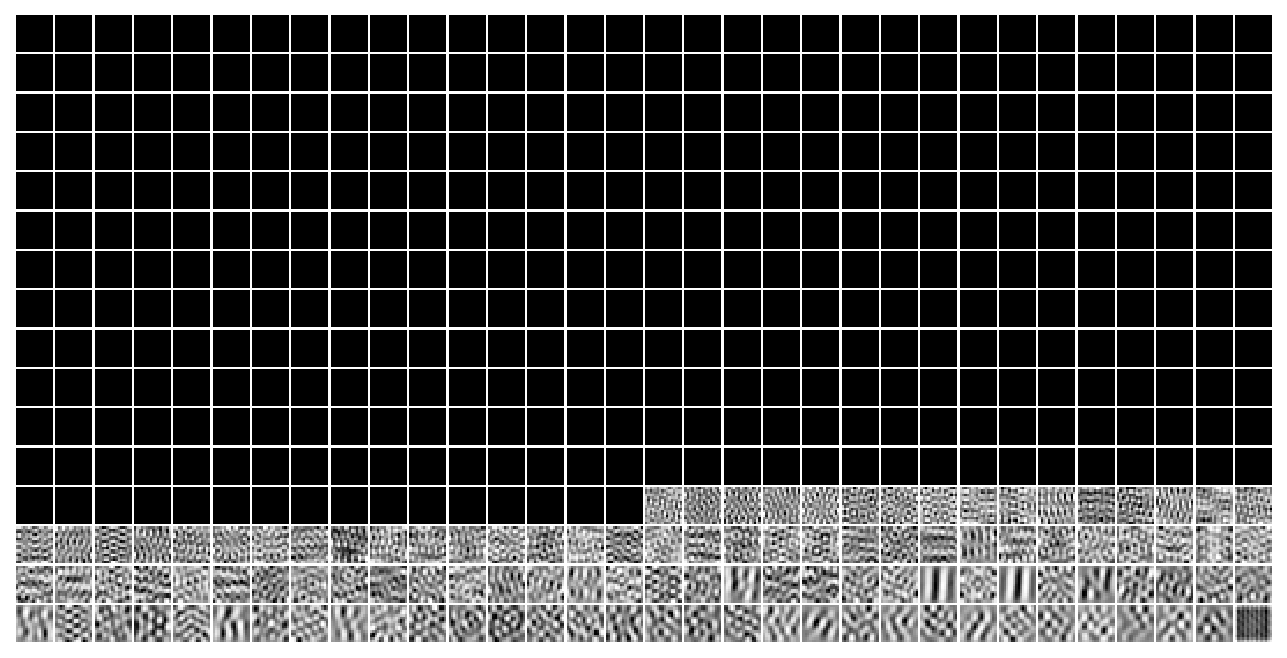

In [20]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

### Laplace

In [21]:
tr = trainers['laplace']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 126.97458, 'kl': 40.408463, 'kl_diag': 0.07842732, 'tot': 167.38304}

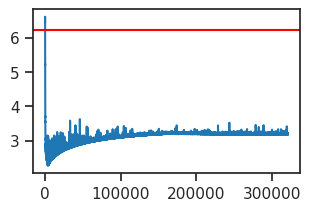

In [22]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

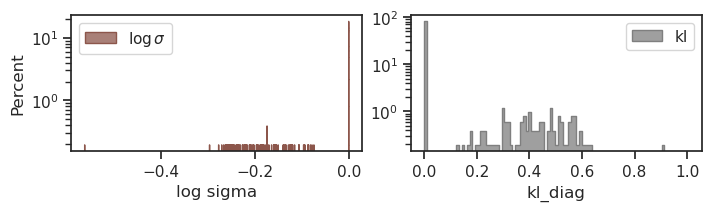

In [23]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [24]:
dead_thres = 8e-2
dead = loss['kl_diag'] < dead_thres
dead.sum()

416

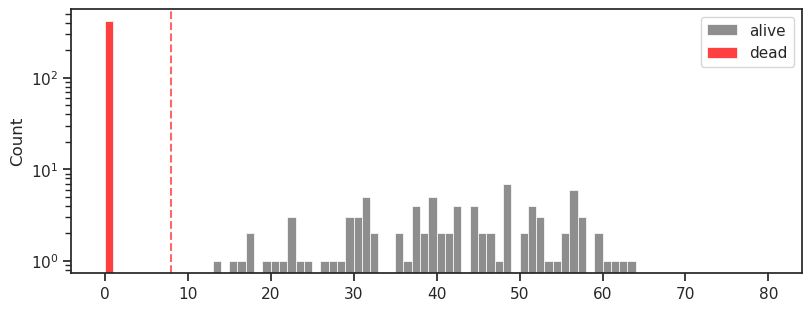

In [25]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
plt.show()

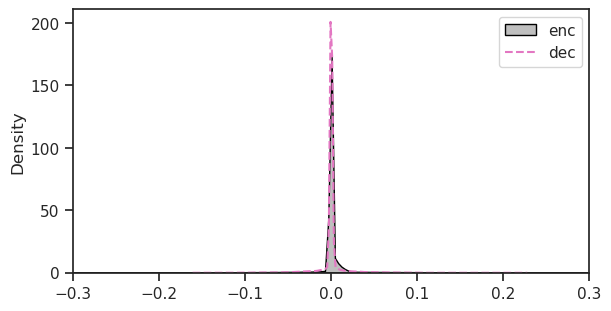

In [26]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

In [27]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

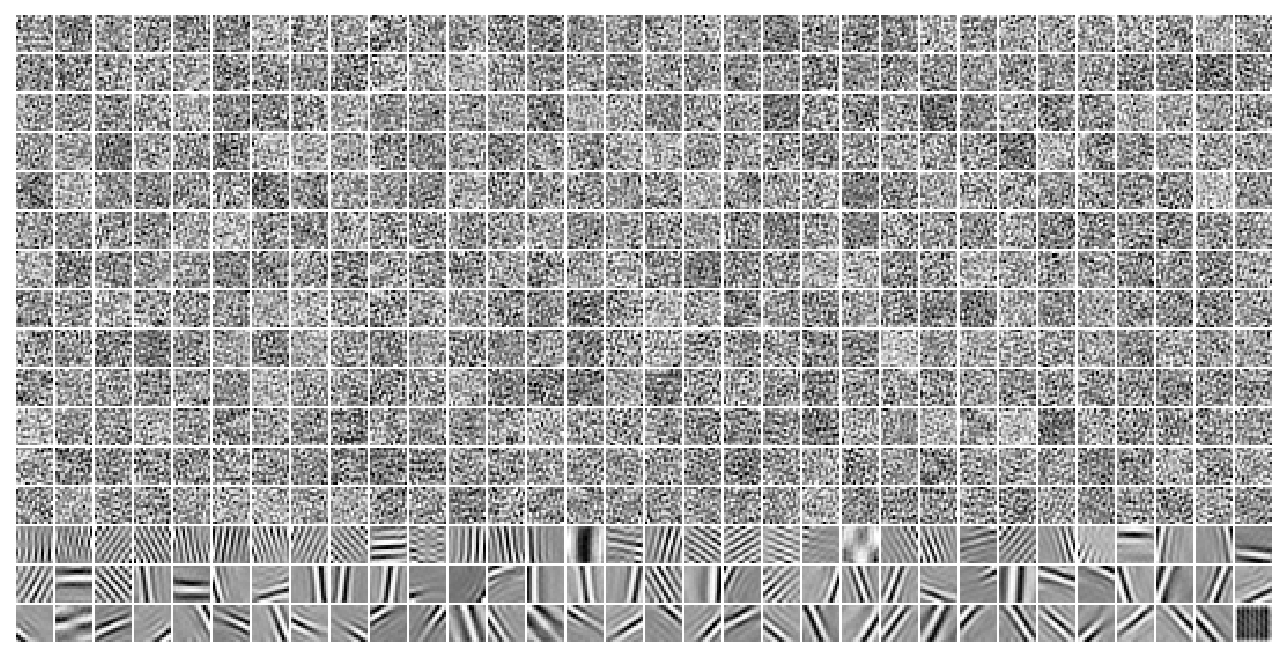

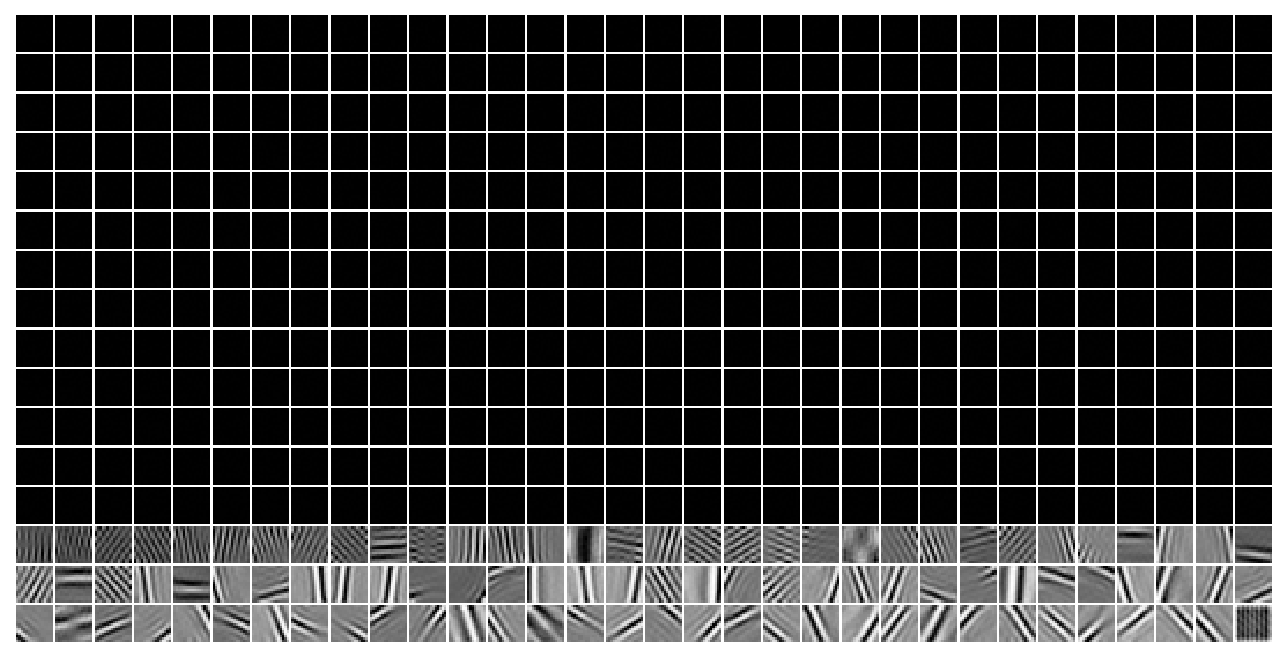

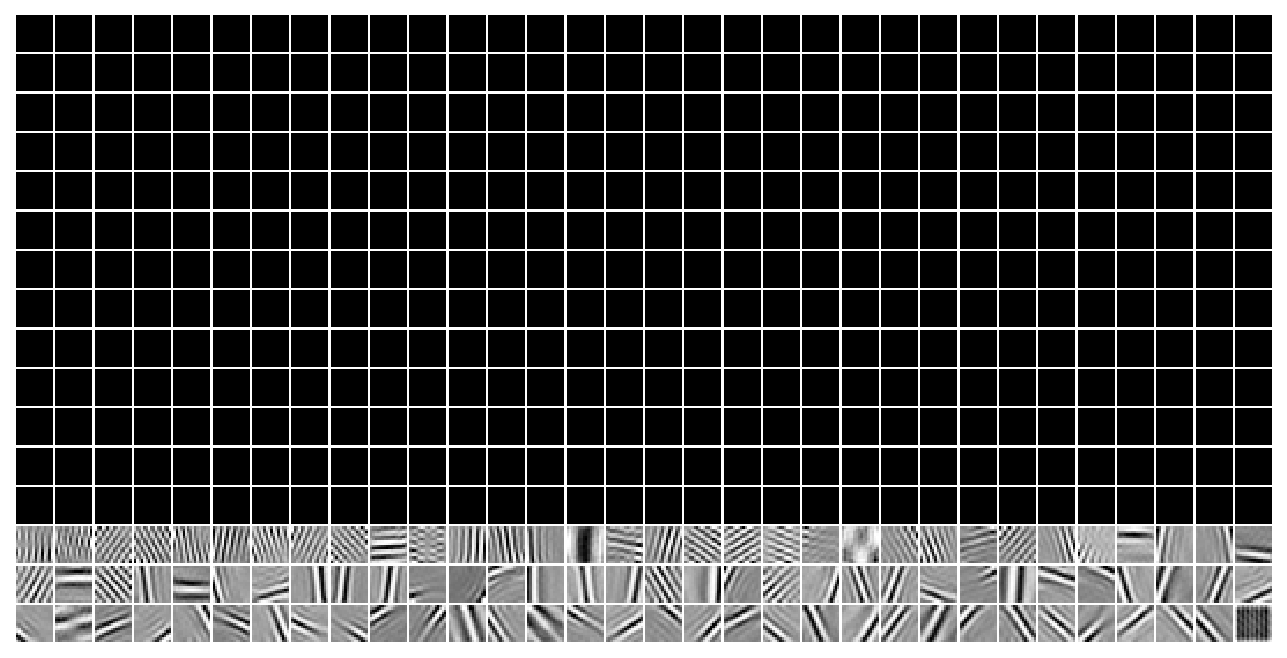

In [28]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

In [29]:
kl = loss['kl_diag'][order]

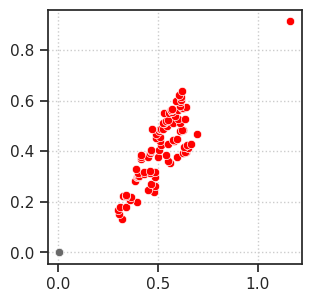

In [30]:
fig, ax = create_figure(1, 1, (3, 3))
sns.scatterplot(x=norms[~dead], y=kl[~dead], color='r', ax=ax)
sns.scatterplot(x=norms[dead], y=kl[dead], color='dimgrey', ax=ax)
ax_square(ax)
ax.grid()
plt.show()

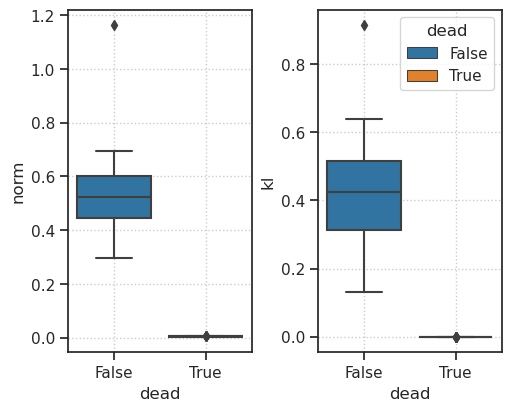

In [31]:
df = pd.DataFrame({'kl': kl, 'norm': norms, 'dead': dead})

fig, axes = create_figure(1, 2, (5, 4))
sns.boxplot(data=df, x='dead', y='norm', hue='dead', dodge=False, ax=axes[0])
sns.boxplot(data=df, x='dead', y='kl', hue='dead', dodge=False, ax=axes[1])
add_grid(axes)
move_legend(axes[0])
plt.show()

### Categorical

In [32]:
tr = trainers['categorical']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 164.98459, 'kl': 5.458941, 'kl_diag': 5.4424906, 'tot': 170.44353}

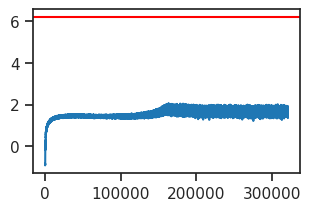

In [33]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

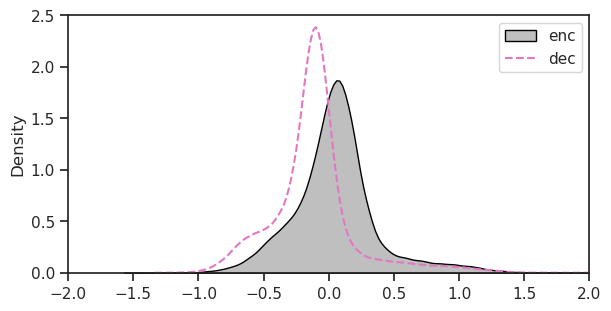

In [34]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-2.0, 2.0))
add_legend(ax)
plt.show()

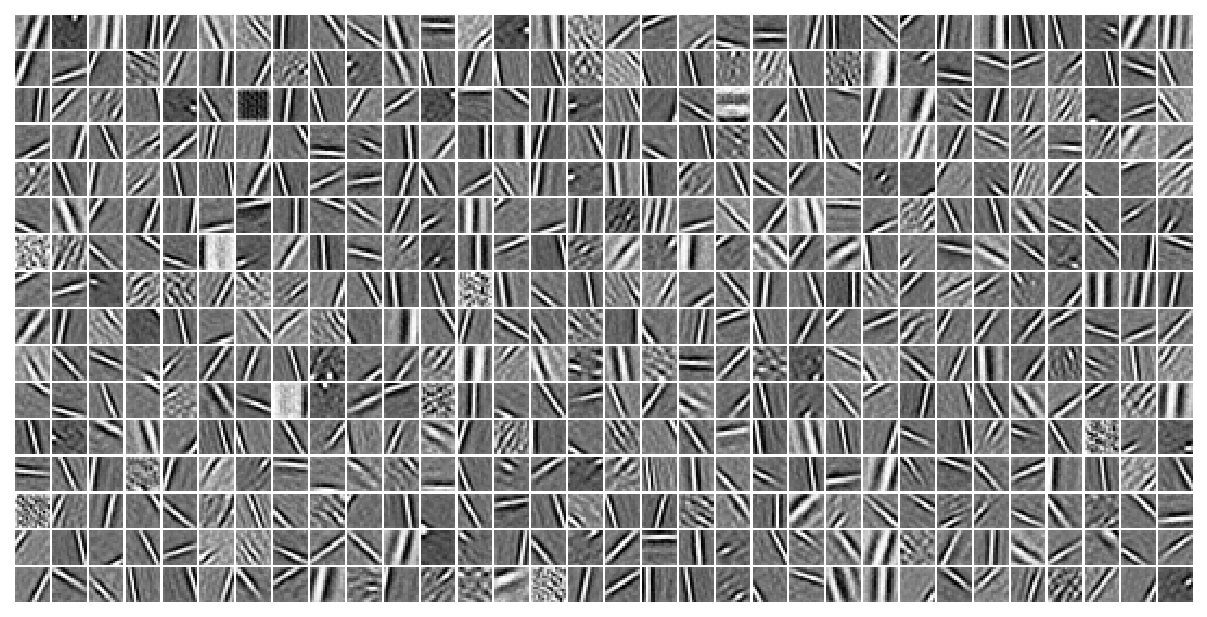

In [35]:
tr.model.show(dpi=150);